In [1]:
!pip install split-folders

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import splitfolders

#1. Define Kaggle Paths
input_folder = '/kaggle/input/image-classification-train-zip/train' 
output_folder = '/kaggle/working/data_split/' 

#2. Split Data (Only needs to run once per session)
print("Splitting source data into train, val, and test sets...")
try:
    # This reads from /kaggle/input and writes to /kaggle/working/
    splitfolders.ratio(input_folder, 
                       output=output_folder, 
                       seed=42, 
                       ratio=(.7, .15, .15)) # 70% train, 15% val, 15% test
    print(f"Data successfully split into '{output_folder}'")
except Exception as e:
    print(f"Could not split folders (maybe already split?): {e}")


#3. Define Image Parameters 
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
seed = 42

#4. Create SEPARATE Generators 
# Generator for TRAINING data (WITH augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Generator for VALIDATION and TEST data (RESCALE ONLY)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- 5. Point Generators to the NEW Folders in /kaggle/working/ ---
train_gen = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # No shuffle for validation
    seed=seed
)

# This is your UNSEEN test set for final evaluation
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  
    seed=seed
)

print("\nGenerators created.")
print("Classes detected:", train_gen.class_indices)

2025-10-23 05:53:33.097535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761198813.126901     123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761198813.135403     123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Splitting source data into train, val, and test sets...


Copying files: 10008 files [00:26, 371.06 files/s]


Data successfully split into '/kaggle/working/data_split/'
Found 7005 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1503 images belonging to 10 classes.

Generators created.
Classes detected: {'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}


In [3]:
#2. Baseline CNN Model (Run 1)
print("\nStarting Run 1: Baseline CNN Model")

model_a = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Anti-overfitting 
    tf.keras.layers.Dense(10, activation='softmax') # 10 classes
])

model_a.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss='categorical_crossentropy', # Correct loss for multi-class
                metrics=['accuracy']) # 'accuracy' is Top-1 Accuracy 

model_a.summary()

# This callback stops training when validation loss stops improving 
callback = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

history_a = model_a.fit(train_gen,
                        validation_data=val_gen,
                        epochs=15,
                        callbacks=[callback])


Starting Run 1: Baseline CNN Model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-23 05:54:43.537473: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 164s 727ms/step - accuracy: 0.1260 - loss: 2.3128 - val_accuracy: 0.1713 - val_loss: 2.2607
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 155s 705ms/step - accuracy: 0.1550 - loss: 2.2437 - val_accuracy: 0.2173 - val_loss: 2.1532
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 157s 716ms/step - accuracy: 0.2134 - loss: 2.1689 - val_accuracy: 0.2567 - val_loss: 2.0827
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 168s 767ms/step - accuracy: 0.2377 - loss: 2.1158 - val_accuracy: 0.2853 - val_loss: 2.0340
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 155s 704ms/step - accuracy: 0.2658 - loss: 2.0583 - val_accuracy: 0.2813 - val_loss: 2.0321
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 158s 719ms/step - accuracy: 0.2838 - loss: 2.0315 - val_accuracy: 0.3013 - val_loss: 1.9732
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 156s 713ms/step - accuracy: 0.2937 - loss: 1.9763 - val_accuracy: 0.2680 - val_loss: 2.0304
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 169s 769ms/step - accuracy: 0.2930 -

In [4]:
#3.Transfer Learning Model (Run 2)
print("\nStarting Run 2: MobileNetV2 (Feature Extraction)")

# Load the base model without its classifier
base = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(128,128,3)
)

# Freeze the base layers
base.trainable = False  

model_b = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3), # Anti-overfitting 
    tf.keras.layers.Dense(10, activation='softmax')
])

model_b.compile(optimizer=tf.keras.optimizers.Adam(1e-4), # Slower LR
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_b.summary()

history_b = model_b.fit(train_gen,
                        validation_data=val_gen,
                        epochs=10,
                        callbacks=[callback])


Starting Run 2: MobileNetV2 (Feature Extraction)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 134s 578ms/step - accuracy: 0.1176 - loss: 2.8567 - val_accuracy: 0.3020 - val_loss: 2.0119
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 549ms/step - accuracy: 0.2742 - loss: 2.2084 - val_accuracy: 0.4473 - val_loss: 1.6771
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 547ms/step - accuracy: 0.3994 - loss: 1.8248 - val_accuracy: 0.5220 - val_loss: 1.5011
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 547ms/step - accuracy: 0.4245 - loss: 1.7532 - val_accuracy: 0.5493 - val_loss: 1.3996
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 547ms/step - accuracy: 0.4679 - loss: 1.6507 - val_accuracy: 0.5660 - val_loss: 1.3348
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 548ms/step - accuracy: 0.4888 - loss: 1.5384 - val_accuracy: 0.5773 - val_loss: 1.2904
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 549ms/step - accuracy: 0.5169 - loss: 1.4530 - val_accuracy: 0.5820 - val_loss: 1.2609
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 546ms/step - accuracy: 0.5172 -

In [5]:
#Transfer Learning Model (Run 3 - Fine-Tuned)

print("\nStarting Run 3: MobileNetV2 (Fine-Tuned Top Layers)")

# Unfreeze the base model
base.trainable = True

# Freeze all layers *except* the top 30
for layer in base.layers[:-30]:
    layer.trainable = False

# Re-compile the model with a very low learning rate
model_b.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_b.summary() # Note the change in trainable params

# Continue training (fine-tuning)
history_finetune = model_b.fit(train_gen,
                               validation_data=val_gen,
                               epochs=10,
                               callbacks=[callback])



Starting Run 3: MobileNetV2 (Fine-Tuned Top Layers)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,539,210 (5.87 MB)

 Non-trainable params: 731,584 (2.79 MB)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 152s 616ms/step - accuracy: 0.4718 - loss: 1.5972 - val_accuracy: 0.6093 - val_loss: 1.1724
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 597ms/step - accuracy: 0.5143 - loss: 1.4599 - val_accuracy: 0.6180 - val_loss: 1.1629
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 136s 619ms/step - accuracy: 0.5458 - loss: 1.3339 - val_accuracy: 0.6213 - val_loss: 1.1477
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 136s 619ms/step - accuracy: 0.5709 - loss: 1.2710 - val_accuracy: 0.6233 - val_loss: 1.1377
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 132s 603ms/step - accuracy: 0.5676 - loss: 1.2749 - val_accuracy: 0.6367 - val_loss: 1.1205
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 599ms/step - accuracy: 0.5972 - loss: 1.2155 - val_accuracy: 0.6400 - val_loss: 1.1105
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 599ms/step - accuracy: 0.6071 - loss: 1.1678 - val_accuracy: 0.6433 - val_loss: 1.1025
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 133s 605ms/step - accuracy: 0.6302 -

In [6]:
#4. Evaluation Section
print("\nEvaluating Models on UNSEEN Test Set...")

def evaluate_model(model, name, generator):
    print(f"\n===== {name} =====")
    
    # 1. Get Top-1 Accuracy 
    # .evaluate() returns [loss, accuracy]
    loss, top1_acc = model.evaluate(generator)
    print(f"Overall Top-1 Accuracy: {top1_acc:.4f}")

    #2. Calculate Average Accuracy per Class 
    
    # Get true labels from the generator
    y_true = generator.classes
    
    # Get predicted probabilities
    y_pred_probs = model.predict(generator)
    
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Generate the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    # Calculate per-class accuracy
    # (Diagonal elements) / (Sum of elements in that row)
    class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
    
    # Calculate the average of per-class accuracies 
    avg_acc = np.mean(class_acc)
    
    print(f"Average Accuracy per Class: {avg_acc:.4f}")
    
    #Print per-class accuracies to see which ones fail
    print("\nPer-Class Accuracy:")
    class_names = list(generator.class_indices.keys())
    for i, acc in enumerate(class_acc):
        print(f"  {class_names[i]:<10}: {acc:.4f}")
        
    return top1_acc, avg_acc

# Evaluate both models on the TEST_GEN 
acc_a, avg_a = evaluate_model(model_a, "Run 1: Baseline CNN", test_gen)
acc_b, avg_b = evaluate_model(model_b, "Run 3: MobileNetV2 Fine-Tuned", test_gen)


Evaluating Models on UNSEEN Test Set...

===== Run 1: Baseline CNN =====
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 473ms/step - accuracy: 0.2659 - loss: 1.9694
Overall Top-1 Accuracy: 0.3407
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step
Average Accuracy per Class: 0.3405

Per-Class Accuracy:
  Amphibia  : 0.1333
  Animalia  : 0.1333
  Arachnida : 0.4803
  Aves      : 0.4533
  Fungi     : 0.3510
  Insecta   : 0.2800
  Mammalia  : 0.3733
  Mollusca  : 0.2067
  Plantae   : 0.5533
  Reptilia  : 0.4400

===== Run 3: MobileNetV2 Fine-Tuned =====
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step - accuracy: 0.6191 - loss: 1.1933
Overall Top-1 Accuracy: 0.6494
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step
Average Accuracy per Class: 0.6494

Per-Class Accuracy:
  Amphibia  : 0.4933
  Animalia  : 0.6533
  Arachnida : 0.5921
  Aves      : 0.8067
  Fungi     : 0.6755
  Insecta   : 0.7200
  Mammalia  : 0.7600
  Mollusca  : 0.6200
  Plantae   : 0.5733
  Reptilia  : 0.6000



Generating training plots...


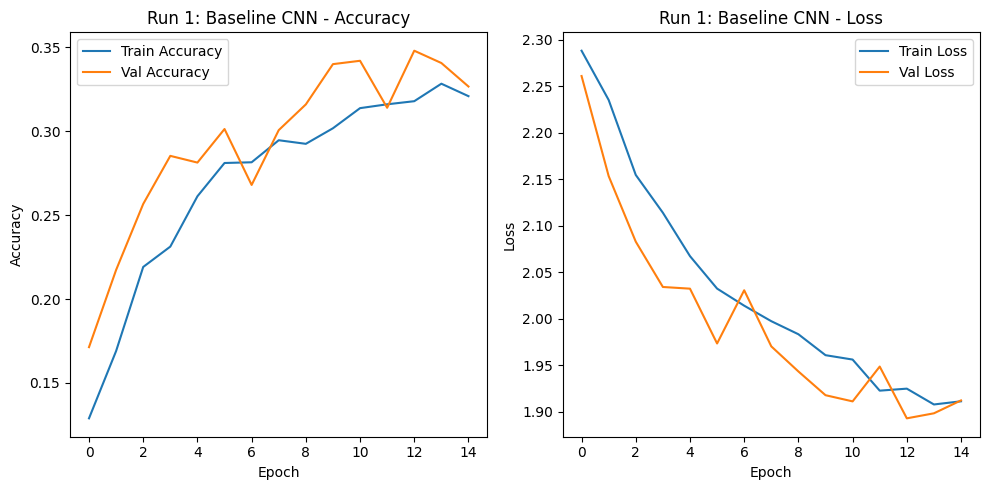

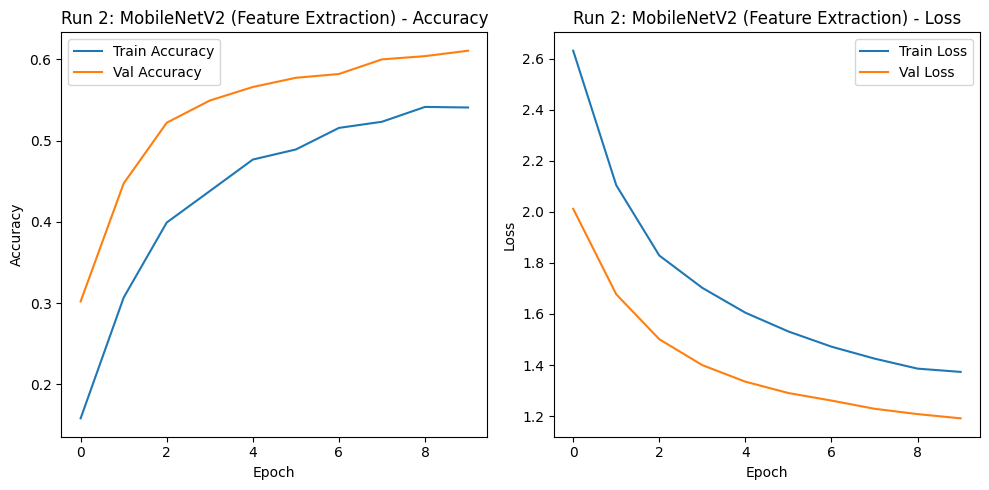

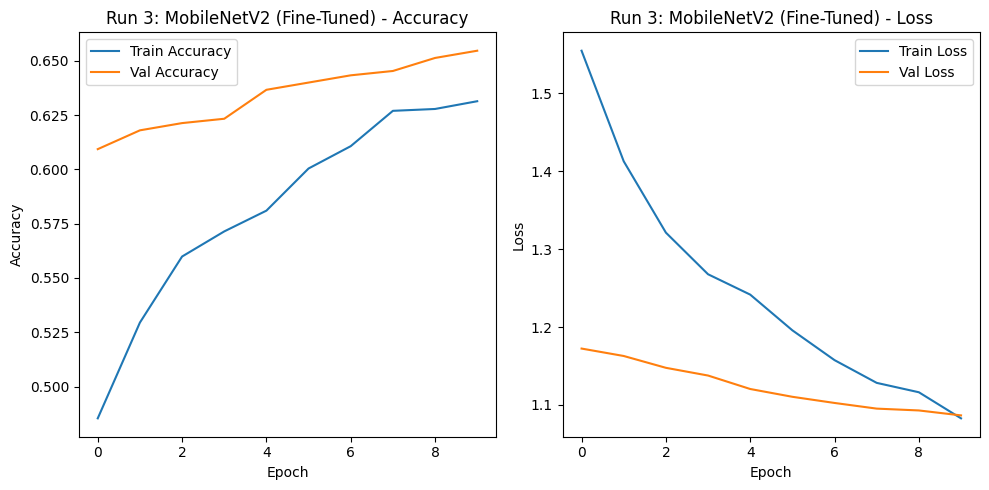


All runs completed successfully!


In [7]:
#5. Visualization Section
print("\nGenerating training plots...")

def plot_history(history, title):
    plt.figure(figsize=(10, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot all three training runs
plot_history(history_a, "Run 1: Baseline CNN")
plot_history(history_b, "Run 2: MobileNetV2 (Feature Extraction)")
plot_history(history_finetune, "Run 3: MobileNetV2 (Fine-Tuned)")

print("\nAll runs completed successfully!")